# QLSD: Quantised Langevin stochastic dynamics for Bayesian federated learning

## Table of contents:
* [Toy Gaussian experiment](#Section-Gaussian)

    * [Figure 1 - MSE for QLSD, QLSD$^\star$ and LSD$^\star$](#subsection-MSE)
    
    * [Figure 1 - MSE behavior w.r.t. compression and discretisation time-step](#subsection-MSE-behavior)

#### Packages

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib import rc
np.random.seed(1994)
%matplotlib inline

rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
rc('text', usetex=True)

#### Useful shared functions

In [200]:
def SQuantization(s,x): 
    
    # s : number of quantization levels
    # x : vector to compress
    
    if s == 0:
        return x
    norm_x = np.linalg.norm(x,2)
    if norm_x == 0:
        return x
    ratio = np.abs(x) / norm_x
    l = np.floor(ratio * s)
    p = ratio * s - l
    sampled = np.random.binomial(1,p)
    qtzt = np.sign(x) * norm_x * (l + sampled) / s
    return qtzt

def com_bits(s,d):
    if s <= np.sqrt(d/2 - np.sqrt(d)):
        return (3 + (3/2) * np.log(2*(s**2 + d)/(s*(s+np.sqrt(d))))) * s*(s+np.sqrt(d)) + 32
    elif s == np.sqrt(d):
        return 2.8*d + 32
    else:
        return ((1/2)*(np.log(1 + (s**2+np.minimum(d,s*np.sqrt(d)))/d) + 1) + 2) * d + 32

## 1. Toy Gaussian experiment <a class="anchor" id="Section-Gaussian"></a>

#### Function to generate data

In [201]:
def generate_data(b,d,n,iid,iid_level,sigma,mu,seed):

    # b : number of clients
    # d : dimension
    # n (array) : number of observations per clients
    # iid : 'True' or 'False'
    # iid_level : B > 0
    
    np.random.seed(seed)
    
    y = []
    labels = []

    if iid == "True":
        for i in range(b):
            y.append(np.random.normal(mu,sigma,size = (n[i],d)))
            labels.append(i * np.ones(n[i]))
    else:
        for i in range(b):
            mu_i = np.random.normal(mu,iid_level)
            y.append(np.random.normal(mu_i,sigma,size = (n[i],d)))
            labels.append(i * np.ones(n[i]))
            
    return y,labels

#### Parameters

In [202]:
## Problem params ##

b = 20 # number of clients
d = 50 # dimension

## Data generation params ##

sigma = 1 # std deviation for data generation
mu = np.zeros(d) # mean vector for data generation
iid_level = 5 # iid level for data generation
np.random.seed(1994)
n = np.random.randint(low=10,high=200,size=b) # number of observations per client

#### Algorithms

In [207]:
mu_true = np.mean(np.concatenate(y,axis=0),axis=0)
cov_true = sigma**2/np.sum(n)

def QLSD_star(T_total,T_bi,T,step_size,init,s):
    
    loss = np.zeros(T)
    theta = np.zeros((T,d))
    theta[0,:] = init
    x = init
    loss[0] = (1/(2*cov_true))*np.linalg.norm(init - mu_true)**2
    
    qgrad = np.zeros((b,d))
    
    thin = int((T_total-T_bi+1)/T)
    
    for t in range(T_total-1):

        for i in range(b):
            qgrad[i,:] = SQuantization(s, n[i] * (x - np.mean(y[i],0))/sigma**2)
                  
        # Update theta on server
        x = x - step_size * np.sum(qgrad,axis=0) + np.sqrt(2*step_size) * np.random.normal(0,1,size=d)
    
        
        if (t % thin == 0) and (t >= T_bi):
            theta[int((t-T_bi)/thin) + 1,:] = x
            loss[int((t-T_bi)/thin) + 1] = (1/(2*cov_true))*np.linalg.norm(x - mu_true)**2
            
    return theta, loss

def QLSD(T_total,T_bi,T,step_size,init,s):
    
    loss = np.zeros(T)
    theta = np.zeros((T,d))
    theta[0,:] = init
    x = init
    loss[0] = (1/(2*cov_true))*np.linalg.norm(init - mu_true)**2
    
    qgrad = np.zeros((b,d))
    
    thin = int((T_total-T_bi+1)/T)
    
    for t in range(T_total-1):

        for i in range(b):    
            idx = np.random.randint(0, n[i])
            qgrad[i,:] = SQuantization(s, n[i] * (x- y[i][idx])/sigma**2)
            
        # Update theta on server
        x = x - step_size * np.sum(qgrad,axis=0) + np.sqrt(2*step_size) * np.random.normal(0,1,size=d)
    
        
        if (t % thin == 0) and (t >= T_bi):
            theta[int((t-T_bi)/thin) + 1,:] = x
            loss[int((t-T_bi)/thin) + 1] = (1/(2*cov_true))*np.linalg.norm(x - mu_true)**2
            
    return theta, loss

def LSD_star(T_total,T_bi,T,step_size,init):
    
    loss = np.zeros(T)
    theta = np.zeros((T,d))
    theta[0,:] = init
    x = init
    loss[0] = (1/(2*cov_true))*np.linalg.norm(init - mu_true)**2
    
    grad = np.zeros((b,d))
    
    thin = int((T_total-T_bi+1)/T)
    
    for t in range(T_total-1):

        for i in range(b):
            grad[i,:] = n[i] * (x - np.mean(y[i],0))/sigma**2
            
                
        # Update theta on server
        x = x - step_size * np.sum(grad,axis=0) + np.sqrt(2*step_size) * np.random.normal(0,1,size=d)
    
        
        if (t % thin == 0) and (t >= T_bi):
            theta[int((t-T_bi)/thin) + 1,:] = x
            loss[int((t-T_bi)/thin) + 1] = (1/(2*cov_true))*np.linalg.norm(x - mu_true)**2
            
    return theta, loss

### 1.1. MSE experiments <a class="anchor" id="subsection-MSE"></a>

In [216]:
## Algorithms params ##
T_tot = 500
T_bi = 0
T = T_tot
L = np.sum(n) / sigma**2
S = [2**4,2**8,2**16]
init = np.zeros(d)
rep = 1 # number of repetitions to compute MSE

theta1 = np.zeros((T,rep,d))
theta2 = np.zeros((T,rep,d))
theta3 = np.zeros((T,rep,d))
theta4 = np.zeros((T,rep,d))
theta5 = np.zeros((T,rep,d))
theta6 = np.zeros((T,rep,d))

for r in range(rep):
    
    # QLSD_star
    theta1[:,r,:], loss1 = QLSD_star(T_tot,T_bi,T,0.01/L,init,S[0])
    theta2[:,r,:], loss2 = QLSD_star(T_tot,T_bi,T,0.01/L,init,S[1])
    theta3[:,r,:], loss3 = QLSD_star(T_tot,T_bi,T,0.01/L,init,S[2])
    
    # QLSD
    theta4[:,r,:], loss4 = QLSD(T_tot,T_bi,T,0.01/L,init,S[0])
    theta5[:,r,:], loss5 = QLSD(T_tot,T_bi,T,0.01/L,init,S[2])
    
    # LSD_star
    theta6[:,r,:], loss5 = LSD_star(T_tot,T_bi,T,0.01/L,init)
    
    print("Repetition n°%i finished."%r)

Repetition n°0 finished.
--- 3.9800302982330322 seconds ---


In [218]:
3.98*1000*30 /(3600)

33.166666666666664

In [163]:
T = 500000
# Plot MSE / number of communicated bits
mu_true = np.mean(np.concatenate(y,axis=0),axis=0)
cov_true = sigma**2/np.sum(n)
est_true = mu_true 

N = 200
Tbi = 450000
TT = [int(((T-Tbi)/N) * (k+1) + Tbi) for k in range(N)]

mse1 = np.zeros(len(TT))
mse2 = np.zeros(len(TT))
mse3 = np.zeros(len(TT))
mse4 = np.zeros(len(TT))
mse5 = np.zeros(len(TT))
mse6 = np.zeros(len(TT))

for t in range(len(TT)):
    
    # QLSD-star 4 bits
    est = np.mean(theta1[Tbi:TT[t],:,:],axis=0)
    Bias2 = np.linalg.norm(np.mean(est,0) - est_true)**2
    Var = np.mean((np.mean(est,0) - est)**2)
    mse1[t] = Bias2 + Var
    
    # QLSD-star 8 bits
    est = np.mean(theta2[Tbi:TT[t],:,:],axis=0)
    Bias2 = np.linalg.norm(np.mean(est,0) - est_true)**2
    Var = np.mean((np.mean(est,0) - est)**2)
    mse2[t] = Bias2 + Var
    
    # QLSD-star 16 bits
    est = np.mean(theta3[Tbi:TT[t],:,:],axis=0)
    Bias2 = np.linalg.norm(np.mean(est,0) - est_true)**2
    Var = np.mean((np.mean(est,0) - est)**2)
    mse3[t] = Bias2 + Var
    
    # QLSD 4 bits
    est = np.mean(theta4[Tbi:TT[t],:,:],axis=0)
    Bias2 = np.linalg.norm(np.mean(est,0) - est_true)**2
    Var = np.mean((np.mean(est,0) - est)**2)
    mse4[t] = Bias2 + Var
    
    # QLSD 16 bits
    est = np.mean(theta5[Tbi:TT[t],:,:],axis=0)
    Bias2 = np.linalg.norm(np.mean(est,0) - est_true)**2
    Var = np.mean((np.mean(est,0) - est)**2)
    mse5[t] = Bias2 + Var
    
    # LSD-star
    est = np.mean(theta6[Tbi:TT[t],:,:],axis=0)
    Bias2 = np.linalg.norm(np.mean(est,0) - est_true)**2
    Var = np.mean((np.mean(est,0) - est)**2)
    mse6[t] = Bias2 + Var

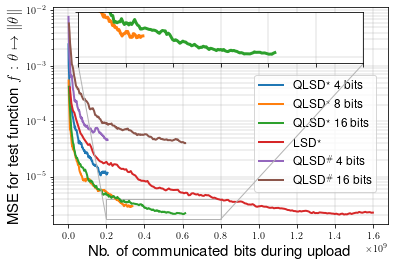

In [199]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset


fig, ax = plt.subplots()
ax.plot([b*com_bits(2**4,d)*(TT[t] - Tbi) for t in range(len(TT))],mse1,lw=2,label=r"QLSD$^{\star}$ 4 bits")
ax.plot([b*com_bits(2**8,d)*(TT[t] - Tbi) for t in range(len(TT))],mse2,lw=2,label=r"QLSD$^{\star}$ 8 bits")
ax.plot([b*com_bits(2**16,d)*(TT[t] - Tbi) for t in range(len(TT))],mse3,lw=2,label=r"QLSD$^{\star}$ 16 bits")
ax.plot([b*32*d*(TT[t] - Tbi) for t in range(len(TT))],mse6,lw=2,label=r"LSD$^{\star}$")
ax.plot([b*com_bits(2**4,d)*(TT[t] - Tbi) for t in range(len(TT))],mse4,lw=2,label=r"QLSD$^\#$ 4 bits")
ax.plot([b*com_bits(2**16,d)*(TT[t] - Tbi) for t in range(len(TT))],mse5,lw=2,label=r"QLSD$^\#$ 16 bits")
plt.yscale('log')

axins = zoomed_inset_axes(ax,zoom=2.5,loc='upper center')
axins.plot([b*com_bits(2**8,d)*(TT[t] - Tbi) for t in range(len(TT))],mse2,lw=3,c='C1')
axins.plot([b*com_bits(2**16,d)*(TT[t] - Tbi) for t in range(len(TT))],mse3,lw=3,c='C2')
x1,x2,y1,y2 = 0.2e9,0.8e9, 1.7e-6,4e-6
axins.set_xlim(x1,x2)
axins.set_ylim(y1,y2)
mark_inset(ax, axins, loc1=4, loc2=3, fc="none", ec="0.7")
from matplotlib.ticker import NullFormatter
axins.yaxis.set_major_formatter(NullFormatter())
axins.xaxis.set_major_formatter(NullFormatter())
axins.grid(True, which="both", ls="-",linewidth=0.4)

ax.grid(True, which="both", ls="-",linewidth=0.4)
ax.set_xlabel('Nb. of communicated bits during upload',size=15)
ax.set_ylabel(r'MSE for test function $f: \theta \mapsto \|\theta\|$',size=15)
ax.legend(prop={'size': 12},loc=(0.6, 0.15))

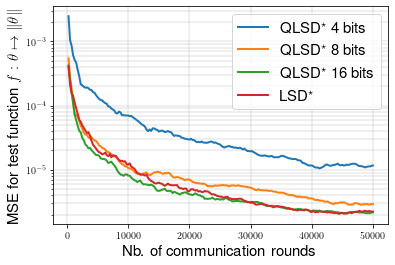

In [190]:
fig, ax = plt.subplots()
ax.plot([(TT[t] - Tbi) for t in range(len(TT))],mse1,lw=2,label=r"QLSD$^{\star}$ 4 bits")
ax.plot([(TT[t] - Tbi) for t in range(len(TT))],mse2,lw=2,label=r"QLSD$^{\star}$ 8 bits")
ax.plot([(TT[t] - Tbi) for t in range(len(TT))],mse3,lw=2,label=r"QLSD$^{\star}$ 16 bits")
ax.plot([(TT[t] - Tbi) for t in range(len(TT))],mse6,lw=2,label=r"LSD$^{\star}$")
plt.yscale('log')

ax.grid(True, which="both", ls="-",linewidth=0.4)
ax.set_xlabel('Nb. of communication rounds',size=15)
ax.set_ylabel(r'MSE for test function $f: \theta \mapsto \|\theta\|$',size=15)
ax.legend(prop={'size': 15})

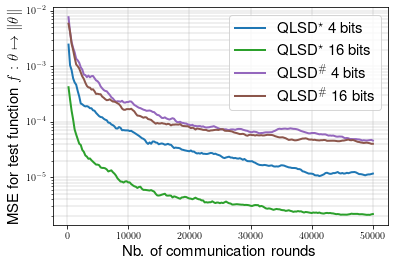

In [196]:
fig, ax = plt.subplots()
ax.plot([(TT[t] - Tbi) for t in range(len(TT))],mse1,lw=2,label=r"QLSD$^{\star}$ 4 bits")
ax.plot([(TT[t] - Tbi) for t in range(len(TT))],mse3,lw=2,label=r"QLSD$^{\star}$ 16 bits",color="C2")
ax.plot([(TT[t] - Tbi) for t in range(len(TT))],mse4,lw=2,label=r"QLSD$^\#$ 4 bits",color="C4")
ax.plot([(TT[t] - Tbi) for t in range(len(TT))],mse5,lw=2,label=r"QLSD$^\#$ 16 bits",color="C5")
plt.yscale('log')

ax.grid(True, which="both", ls="-",linewidth=0.4)
ax.set_xlabel('Nb. of communication rounds',size=15)
ax.set_ylabel(r'MSE for test function $f: \theta \mapsto \|\theta\|$',size=15)
ax.legend(prop={'size': 15})

### 1.2. Behavior of MSE with respect to compression and discretisation time-step <a class="anchor" id="subsection-MSE-behavior"></a>

In [149]:
## Algorithms params ##
bits_constraint = 10**6
p = 0.1
L = np.sum(n) / sigma**2
K = 1
init = np.zeros(d)
rep = 30 # number of repetitions to compute MSE
S = np.logspace(0,4,20)
T_tot = [int(bits_constraint/(b*com_bits(S[s],d))) for s in range(len(S))]
T_bi = 0
T = T_tot

# Plot MSE / number of communicated bits
mu_true = np.mean(np.concatenate(y,axis=0),axis=0)
cov_true = sigma**2/np.sum(n)
est_true = mu_true


mse1 = np.zeros(len(S))
mse2 = np.zeros(len(S))
mse3 = np.zeros(len(S))
mse4 = np.zeros(len(S))
mse5 = np.zeros(len(S))
mse6 = np.zeros(len(S))
mse7 = np.zeros(len(S))
mse8 = np.zeros(len(S))

for s in range(len(S)):
    theta1 = np.zeros((T[s],rep,d))
    theta2 = np.zeros((T[s],rep,d))
    theta3 = np.zeros((T[s],rep,d))
    theta4 = np.zeros((T[s],rep,d))
    theta5 = np.zeros((T[s],rep,d))
    theta4 = np.zeros((T[s],rep,d))
    theta6 = np.zeros((T[s],rep,d))
    theta7 = np.zeros((T[s],rep,d))
    theta8 = np.zeros((T[s],rep,d))
    for r in range(rep):
        
        theta1[:,r,:], loss1 = QLSD_star(T_tot[s],T_bi,T[s],1/L,init,S[s])
        theta2[:,r,:], loss1 = QLSD_star(T_tot[s],T_bi,T[s],0.8/L,init,S[s])
        theta3[:,r,:], loss1 = QLSD_star(T_tot[s],T_bi,T[s],0.6/L,init,S[s])
        theta4[:,r,:], loss1 = QLSD_star(T_tot[s],T_bi,T[s],0.5/L,init,S[s])
        theta5[:,r,:], loss1 = QLSD_star(T_tot[s],T_bi,T[s],0.4/L,init,S[s])
        theta6[:,r,:], loss1 = QLSD_star(T_tot[s],T_bi,T[s],0.2/L,init,S[s])
        theta7[:,r,:], loss1 = QLSD_star(T_tot[s],T_bi,T[s],0.1/L,init,S[s])
        theta8[:,r,:], loss1 = QLSD_star(T_tot[s],T_bi,T[s],0.09/L,init,S[s])
        
        print("Repetition n°%i finished."%r)
        
    est = np.mean(theta1,axis=0)
    Bias2 = np.linalg.norm(np.mean(est,0) - est_true)**2
    Var = np.mean(np.linalg.norm(np.mean(est,0) - est,axis=1)**2,axis=0)
    mse1[s] = Bias2 + Var
    
    est = np.mean(theta2,axis=0)
    Bias2 = np.linalg.norm(np.mean(est,0) - est_true)**2
    Var = np.mean(np.linalg.norm(np.mean(est,0) - est,axis=1)**2,axis=0)
    mse2[s] = Bias2 + Var
    
    est = np.mean(theta3,axis=0)
    Bias2 = np.linalg.norm(np.mean(est,0) - est_true)**2
    Var = np.mean(np.linalg.norm(np.mean(est,0) - est,axis=1)**2,axis=0)
    mse3[s] = Bias2 + Var
    
    est = np.mean(theta4,axis=0)
    Bias2 = np.linalg.norm(np.mean(est,0) - est_true)**2
    Var = np.mean(np.linalg.norm(np.mean(est,0) - est,axis=1)**2,axis=0)
    mse4[s] = Bias2 + Var
    
    est = np.mean(theta5,axis=0)
    Bias2 = np.linalg.norm(np.mean(est,0) - est_true)**2
    Var = np.mean(np.linalg.norm(np.mean(est,0) - est,axis=1)**2,axis=0)
    mse5[s] = Bias2 + Var
    
    est = np.mean(theta6,axis=0)
    Bias2 = np.linalg.norm(np.mean(est,0) - est_true)**2
    Var = np.mean(np.linalg.norm(np.mean(est,0) - est,axis=1)**2,axis=0)
    mse6[s] = Bias2 + Var
    
    est = np.mean(theta7,axis=0)
    Bias2 = np.linalg.norm(np.mean(est,0) - est_true)**2
    Var = np.mean(np.linalg.norm(np.mean(est,0) - est,axis=1)**2,axis=0)
    mse7[s] = Bias2 + Var
    
    est = np.mean(theta8,axis=0)
    Bias2 = np.linalg.norm(np.mean(est,0) - est_true)**2
    Var = np.mean(np.linalg.norm(np.mean(est,0) - est,axis=1)**2,axis=0)
    mse8[s] = Bias2 + Var
        
    print(s)
    